In [25]:
import numpy as np
import copy
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt

%matplotlib inline  #the resulting image is rendered as a static PNG directly below the code cell that produced it.
%load_ext autoreload #it simply activates the functionality so that you can use the %autoreload command
%autoreload 2 #Reload all modules (except those excluded) every time before executing the Python code typed

UsageError: unrecognized arguments: #the resulting image is rendered as a static PNG directly below the code cell that produced it.


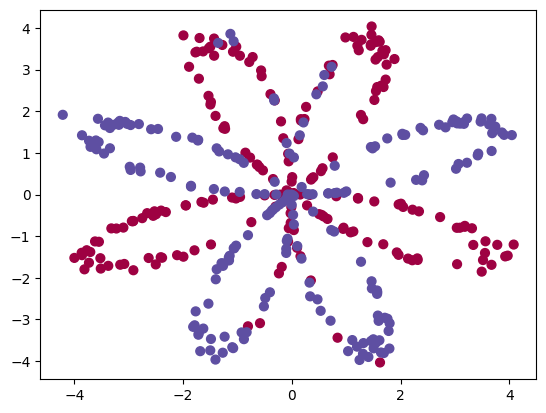

In [26]:
#Load the dataset
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

X, Y = load_planar_dataset()
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

In [27]:
print ('The shape of X is: ' + str(X.shape))
print ('The shape of Y is: ' + str(Y.shape))
print ('I have m = %d training examples!' % (X.shape[1]))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!


In [28]:
#Let us check Logistic regression performance first. 

# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T);


/Users/olaoluadisa/Documents/WEBDEV1/webdev/code files/codefiles/MLspecial/MLSpe_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.5, 1.0, 'Logistic Regression')

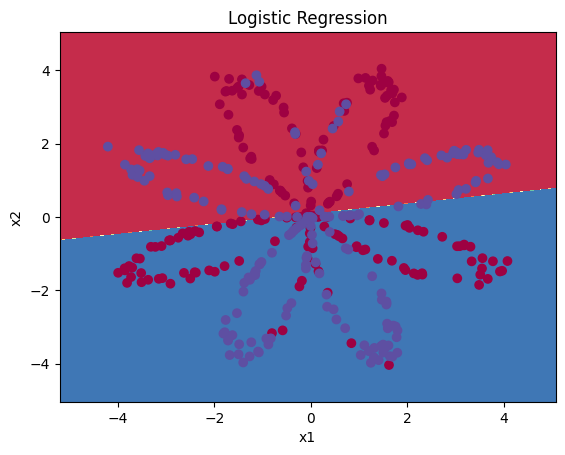

In [29]:
#Decision Boundary helper function
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)


# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")



In [30]:
# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) + '% ' + "(percentage of correctly labelled datapoints)")

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


/var/folders/hf/81yfsz694rx2svmh31g42bb80000gn/T/ipykernel_36652/1276322122.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) + '% ' + "(percentage of correctly labelled datapoints)")


Interpretation: The dataset is not linearly separable, so logistic regression doesn't perform well. 
Hopefully a neural network will do better. Let's try this now!
Next, you're going to train a Neural Network with a single hidden layer and see how that handles the same problem.

The general methodology to build a Neural Network is to: 
1. Define the neural network structure ( # of input units, # of hidden units, etc). 
2. Initialize the model's parameters 
3. Loop: - Implement forward propagation - Compute loss - Implement backward propagation to get the gradients - Update parameters (gradient descent)

In practice, you'll often build helper functions to compute steps 1-3, 
then merge them into one function called nn_model().
Once you've built nn_model() and learned the right parameters, you can make predictions on new data.

In [31]:
#1. Define the neural network structure ( # of input units, # of hidden units, etc). 
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    """
    n_x = X.shape[0] # size of input layer
    n_h = 4          # size of hidden layer 
    n_y = Y.shape[0] # size of output layer
    return (n_x, n_h, n_y)
    
def layer_sizes_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(5, 3)
    Y_assess = np.random.randn(2, 3)
    return X_assess, Y_assess

t_X, t_Y = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(t_X, t_Y)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))


The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


In [32]:
#2. Initialize the model's parameters 
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer

    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """

    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters



In [33]:
n_x, n_h, n_y = 2, 4, 1
parameters = initialize_parameters(n_x, n_h, n_y)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))


W1 = [[ 0.01144724  0.00901591]
 [ 0.00502494  0.00900856]
 [-0.00683728 -0.0012289 ]
 [-0.00935769 -0.00267888]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[ 0.00530355 -0.00691661 -0.00396754 -0.00687173]]
b2 = [[0.]]


In [34]:
#3. Loop: - Implement forward propagation - Compute loss - Implement backward propagation to get the gradients 
#- Update parameters (gradient descent)

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)

    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Implement Forward Propagation to calculate A2 (probabilities)
   

    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1) #tanh activation function used for first hidden layer
    Z2 = np.dot(W2, A1) + b2
    A2 = 1 / (1 + np.exp(-Z2))

    assert(A2.shape == (1, X.shape[1]))

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}

    return A2, cache

#define a test case
def forward_propagation_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    b1 = np.random.randn(4,1)
    b2 = np.array([[ -1.3]])

    parameters = {'W1': np.array([[-0.00416758, -0.00056267],
        [-0.02136196,  0.01640271],
        [-0.01793436, -0.00841747],
        [ 0.00502881, -0.01245288]]),
     'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
     'b1': b1,
     'b2': b2}

    return X_assess, parameters

In [35]:
t_X, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(t_X, parameters)
print("A2 = " + str(A2))

A2 = [[0.21292656 0.21274673 0.21295976]]


In [36]:
#Compute Cost
import numpy as np

def compute_cost(A2, Y):
    """
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    """
    m = Y.shape[1]  # number of examples

    """ Optional code Avoid log(0) by clipping probabilities
    epsilon = 1e-8
    A2 = np.clip(A2, epsilon, 1 - epsilon)
    """

    # Cross-entropy cost
    logprobs = Y * np.log(A2) + (1 - Y) * np.log(1 - A2)
    cost = -np.sum(logprobs) / m

    cost = float(np.squeeze(cost))  # [[17]] → 17
    return cost

In [37]:
def compute_cost_test_case():
    np.random.seed(1)
    Y_assess = (np.random.randn(1, 3) > 0)

    a2 = (np.array([[ 0.5002307 ,  0.49985831,  0.50023963]]))
    
    return a2, Y_assess

A2, t_Y = compute_cost_test_case()
cost = compute_cost(A2, t_Y)
print("cost = " + str(compute_cost(A2, t_Y)))

cost = 0.6930587610394646


Lets Perform Backpropagation
Using the cache computed during forward propagation, we can now implement backward propagation.

In [38]:
def backward_propagation(parameters, cache, X, Y):
    """

    Arguments:
    parameters -- python dictionary containing our parameters
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]

    W1 = parameters["W1"]   # shape (n_h, n_x)
    W2 = parameters["W2"]   # shape (n_y, n_h)
    A1 = cache["A1"]        # shape (n_h, m)
    A2 = cache["A2"]        # shape (n_y, m)

    # Backward pass
    dZ2 = A2 - Y                                 # shape (n_y, m)
    dW2 = np.dot(dZ2, A1.T) / m                  # shape (n_y, n_h)
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m  # shape (n_y, 1)

    dA1 = np.dot(W2.T, dZ2)                      # shape (n_h, m)
    dZ1 = dA1 * (1 - np.power(A1, 2))            # derivative of tanh
    dW1 = np.dot(dZ1, X.T) / m                   # shape (n_h, n_x)
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m  # shape (n_h, 1)



    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}

    return grads



def backward_propagation_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    Y_assess = (np.random.randn(1, 3) > 0)
    parameters = {'W1': np.array([[-0.00416758, -0.00056267],
        [-0.02136196,  0.01640271],
        [-0.01793436, -0.00841747],
        [ 0.00502881, -0.01245288]]),
     'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
     'b1': np.array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]),
     'b2': np.array([[ 0.]])}

    cache = {'A1': np.array([[-0.00616578,  0.0020626 ,  0.00349619],
         [-0.05225116,  0.02725659, -0.02646251],
         [-0.02009721,  0.0036869 ,  0.02883756],
         [ 0.02152675, -0.01385234,  0.02599885]]),
  'A2': np.array([[ 0.5002307 ,  0.49985831,  0.50023963]]),
  'Z1': np.array([[-0.00616586,  0.0020626 ,  0.0034962 ],
         [-0.05229879,  0.02726335, -0.02646869],
         [-0.02009991,  0.00368692,  0.02884556],
         [ 0.02153007, -0.01385322,  0.02600471]]),
  'Z2': np.array([[ 0.00092281, -0.00056678,  0.00095853]])}
    return parameters, cache, X_assess, Y_assess

In [39]:
#parameters, cache, t_X, t_Y = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, t_X, t_Y)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00062204 -0.00022325]
 [ 0.00256071 -0.0009007 ]
 [-0.00255154  0.00092684]
 [-0.01102494  0.00387834]]
db1 = [[ 0.00015108]
 [ 0.00055033]
 [-0.00062416]
 [-0.00264558]]
dW2 = [[-0.11309032  0.08517812 -0.03030497  0.02491779]]
db2 = [[-0.12045565]]


In [40]:
#Update Paramaters

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Arguments:
    parameters -- python dictionary containing your parameters
    grads -- python dictionary containing your gradients

    Returns:
    parameters -- python dictionary containing your updated parameters
    """
    W1 = copy.deepcopy(parameters["W1"])
    b1 = copy.deepcopy(parameters["b1"])
    W2 = copy.deepcopy(parameters["W2"])
    b2 = copy.deepcopy(parameters["b2"])
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    # Update rule for each parameter

    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

In [41]:
def update_parameters_test_case():
    parameters = {'W1': np.array([[-0.00615039,  0.0169021 ],
        [-0.02311792,  0.03137121],
        [-0.0169217 , -0.01752545],
        [ 0.00935436, -0.05018221]]),
 'W2': np.array([[-0.0104319 , -0.04019007,  0.01607211,  0.04440255]]),
 'b1': np.array([[ -8.97523455e-07],
        [  8.15562092e-06],
        [  6.04810633e-07],
        [ -2.54560700e-06]]),
 'b2': np.array([[  9.14954378e-05]])}

    grads = {'dW1': np.array([[ 0.00023322, -0.00205423],
        [ 0.00082222, -0.00700776],
        [-0.00031831,  0.0028636 ],
        [-0.00092857,  0.00809933]]),
 'dW2': np.array([[ -1.75740039e-05,   3.70231337e-03,  -1.25683095e-03,
          -2.55715317e-03]]),
 'db1': np.array([[  1.05570087e-07],
        [ -3.81814487e-06],
        [ -1.90155145e-07],
        [  5.46467802e-07]]),
 'db2': np.array([[ -1.08923140e-05]])}
    return parameters, grads

In [42]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


In [43]:
#Integrate all function and define the model
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations

    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    parameters = initialize_parameters(n_x, n_h, n_y)

    # Loop (gradient descent)

    for i in range(0, num_iterations):
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads)

        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [44]:
#test the Model
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X

    Arguments:
    parameters -- python dictionary containing your parameters
    X -- input data of size (n_x, m)

    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """

    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5).astype(int)

    return predictions

In [45]:
def predict_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    parameters = {'W1': np.array([[-0.00615039,  0.0169021 ],
        [-0.02311792,  0.03137121],
        [-0.0169217 , -0.01752545],
        [ 0.00935436, -0.05018221]]),
     'W2': np.array([[-0.0104319 , -0.04019007,  0.01607211,  0.04440255]]),
     'b1': np.array([[ -8.97523455e-07],
        [  8.15562092e-06],
        [  6.04810633e-07],
        [ -2.54560700e-06]]),
     'b2': np.array([[  9.14954378e-05]])}
    return parameters, X_assess

In [46]:
parameters, t_X = predict_test_case()

predictions = predict(parameters, t_X)
print("Predictions: " + str(predictions))


Predictions: [[1 0 1]]


Cost after iteration 0: 0.693162
Cost after iteration 1000: 0.258625
Cost after iteration 2000: 0.239334
Cost after iteration 3000: 0.230802
Cost after iteration 4000: 0.225528
Cost after iteration 5000: 0.221845
Cost after iteration 6000: 0.219094
Cost after iteration 7000: 0.220588
Cost after iteration 8000: 0.219405
Cost after iteration 9000: 0.218524


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

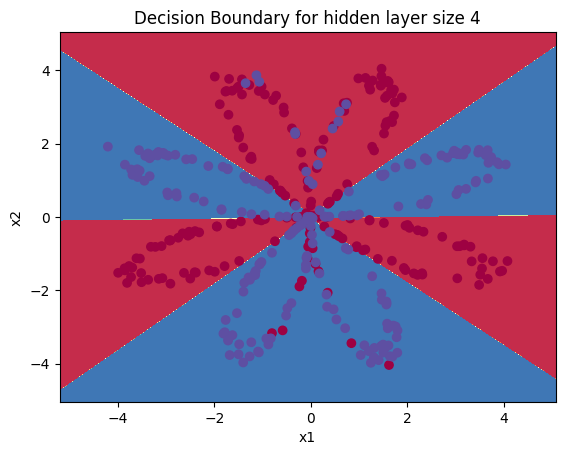

In [47]:
# Finally, time to test this model on the Original Planar Dataset from the beggining of this notebook
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [48]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

Accuracy: 90%


/var/folders/hf/81yfsz694rx2svmh31g42bb80000gn/T/ipykernel_36652/1304927518.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')


Accuracy is really high compared to Logistic Regression. The model has learned the patterns of the flower's petals!
Unlike logistic regression, neural networks are able to learn even highly non-linear decision boundaries.

/var/folders/hf/81yfsz694rx2svmh31g42bb80000gn/T/ipykernel_36652/3811120821.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accuracy = float((np.dot(Y,predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size)*100)


Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 90.75 %
Accuracy for 50 hidden units: 90.25 %


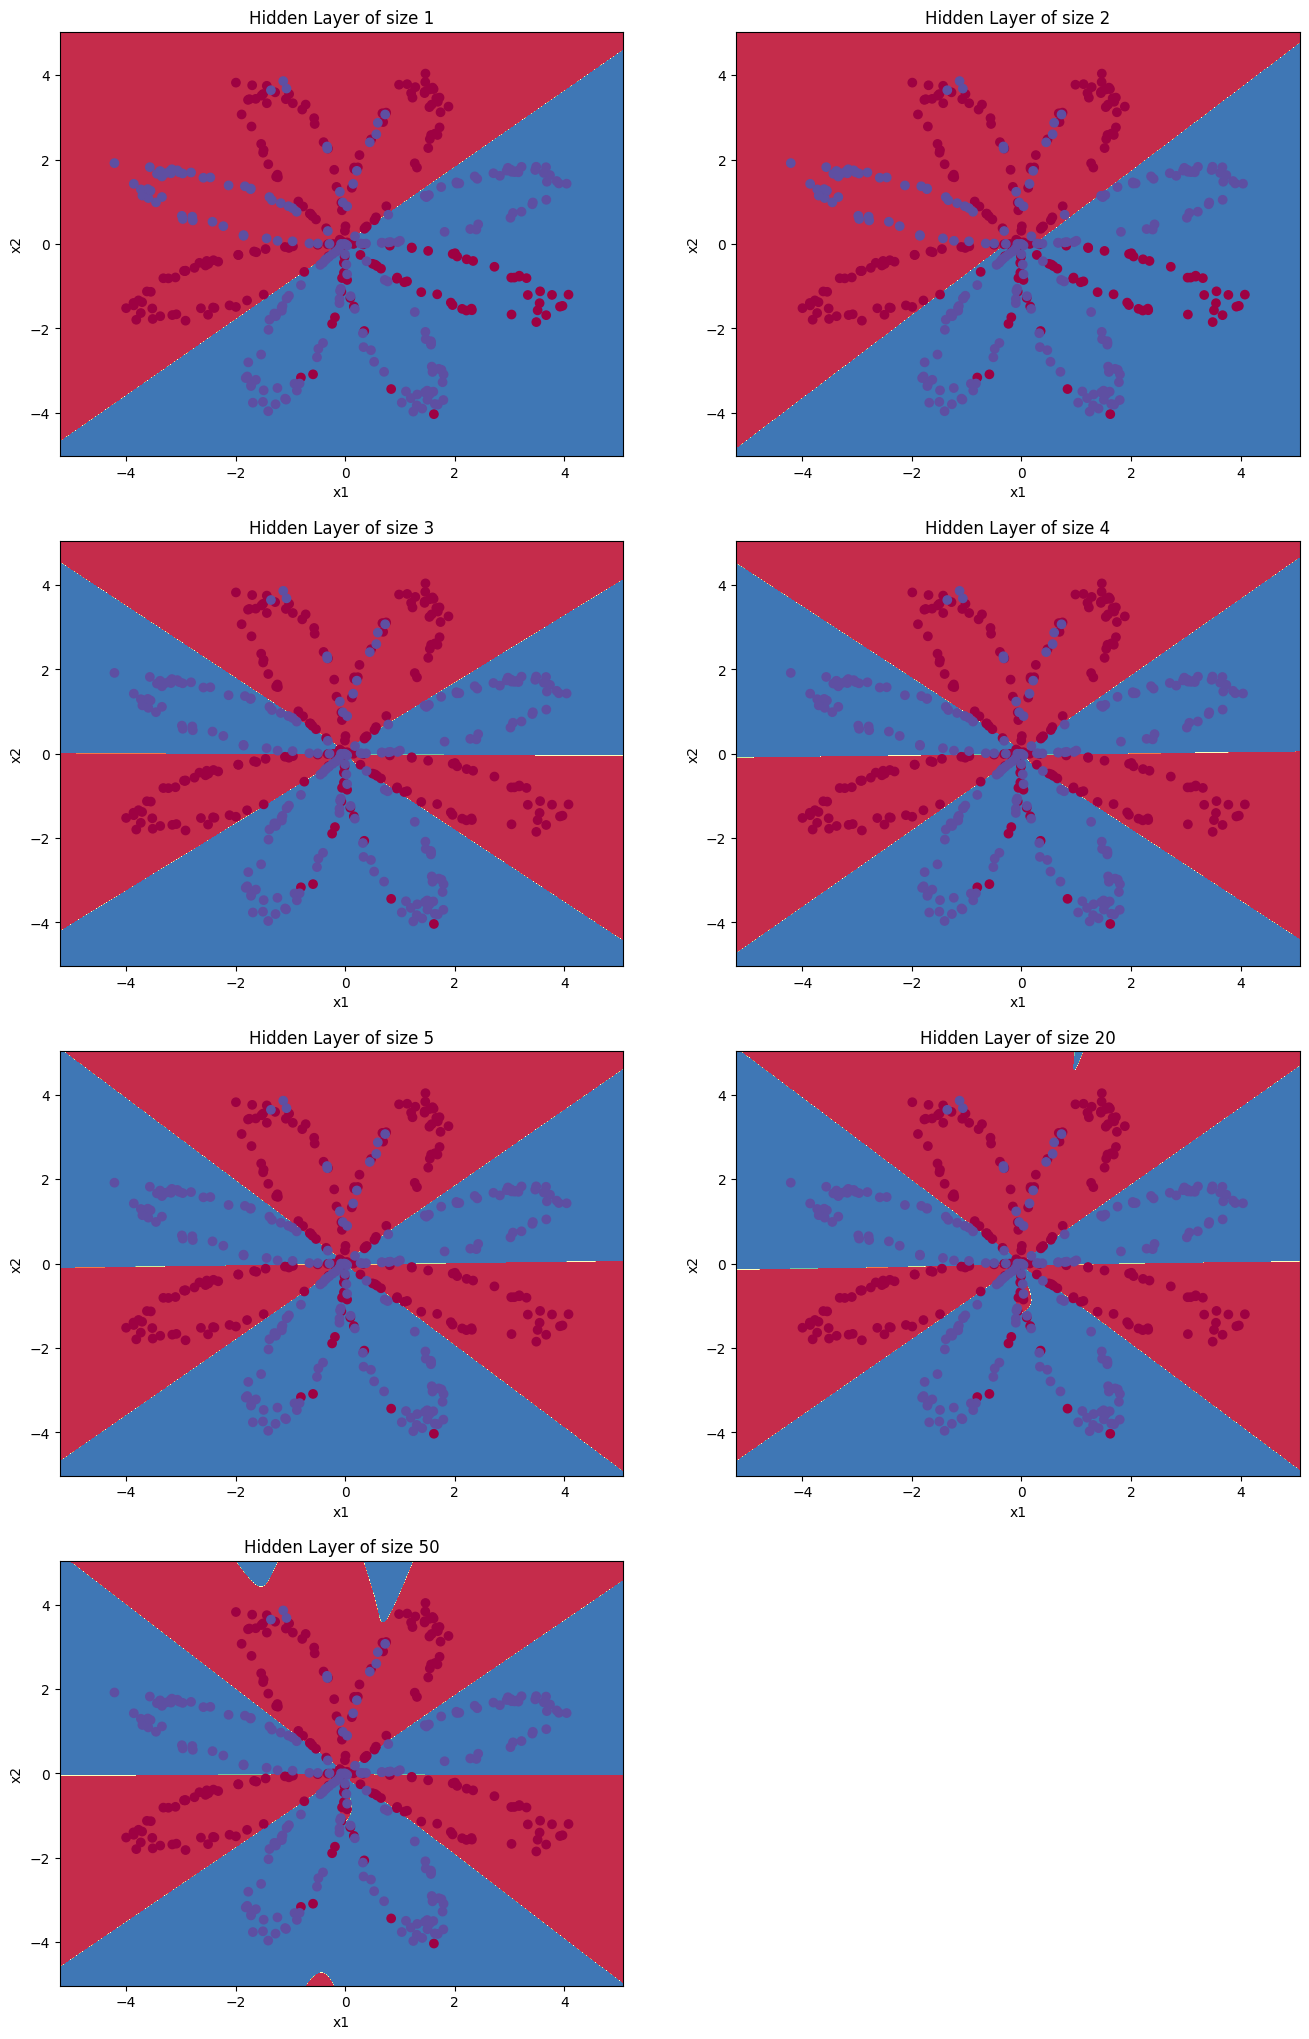

In [51]:
# Tuning hidden layer size
#This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5]

# you can try with different hidden layer sizes

hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]

for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

You can seee accuray peaked at 5 hidden layers. So, adding more layers does not aways increase accuracy.
We can try other  dataset. you can rerun the whole notebook (minus the dataset part) for each of the following datasets.

In [56]:
def load_extra_datasets():  
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)
    
    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

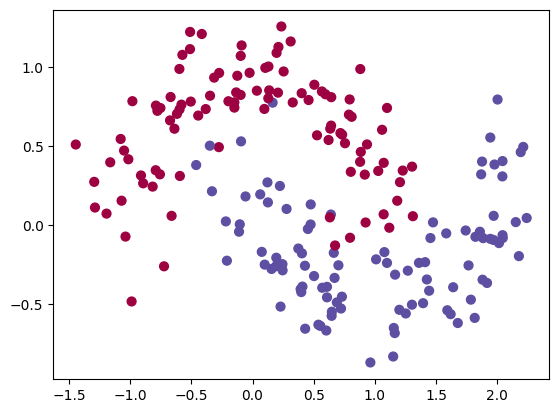

In [58]:
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()
datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

# choose your dataset here
dataset = "noisy_moons"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);